In [1]:
#from spark_setup import SparkSetup
#from setup_data_gaia_dr3 import SetupDataGaiaDR3
#spark_setup = SparkSetup(pods=55, cpu=2, mem=20, dmem=20, data_setup=SetupDataGaiaDR3)
#spark_gaia = spark_setup.get_spark_session()
#sc = spark_gaia.sparkContext

In [2]:
# pods = 18
# cpu  = 5
# mem  = 52
# tot_mem = pods*mem
# tot_cpu = pods*cpu
# spark_setup = SparkSetup(pods=pods, cpu=cpu, mem=mem, data_setup=SetupDataGaiaDR3)
# print(f"Total memory: {tot_mem}\nTotal CPUs: {tot_cpu}")
# spark = spark_setup.get_spark_session()

Beginning the initialization of a spark cluster with 18 pods, 5 cores/pod and 52g mem/pod


25/12/09 13:51:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/09 13:51:09 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 51730. Attempting port 51731.


Completed initialisation
Setting up SparkSQL
Setting up dataset Gaia DR3 with 2 databases gaiadr3, gaiaedr3
Total memory: 936
Total CPUs: 90


# Importing Stuff

## Import the spark config

In [3]:
from astroflow_spark_gaia import spark

## Import some libraries

In [4]:
import hdbscan
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from astropy import units as u
import matplotlib.pyplot as plt
import healpy as hp
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, LongType, FloatType, DoubleType, StringType
)
import math
from pyspark.sql import functions as F

In [5]:
def get_healpix_level_n(n, source_id):
    """
    Get the healpix level n for a given source_id
    """
    
    source_id = np.array(source_id)
    healpix_n = source_id // ((2**35)*(4**(12 - n)))
    return healpix_n

### Plotting Function

In [6]:
def plot_clustering_output(cluster_field_df, cmap = 'spring', plot_noise=True, facecolor='white', cluster_label_col = 'cluster_label'):
    cluster_field_df['g_rp'] = cluster_field_df['phot_g_mean_mag'] - cluster_field_df['phot_rp_mean_mag']
    fg, axs = plt.subplots(2, 2, figsize=(8, 8))

    # cluster_label_hdbscan = -1 is noise hence should be smaller in size and gray
    noise_stars = cluster_field_df[cluster_field_df[cluster_label_col] == -1]
    if facecolor == 'black':
        noise_color = 'lightgray'
    else:
        noise_color = 'gray'
    if plot_noise:
        axs[0, 0].scatter(noise_stars['l'], noise_stars['b'], color=noise_color, s=0.5, label='Noise')
        axs[0, 1].scatter(noise_stars['pmra'], noise_stars['parallax'], color=noise_color, s=0.5, label='Noise')
        axs[1, 0].scatter(noise_stars['pmra'], noise_stars['pmdec'], color=noise_color, s=0.5, label='Noise')
        axs[1, 1].scatter(noise_stars['g_rp'], noise_stars['phot_g_mean_mag'], color=noise_color, s=0.5, label='Noise')

    clustered_stars = cluster_field_df[cluster_field_df[cluster_label_col] != -1]

    # sort the clustered stars based on size of their clusters so that larger clusters are plotted first
    clustered_stars = clustered_stars.sort_values(by=cluster_label_col, 
                                                  key=lambda x: x.map(clustered_stars[cluster_label_col].value_counts()),
                                                  ascending=False)
    
    # the size of points should be dependent on the number of stars in a particular cluster
    cluster_sizes = clustered_stars[cluster_label_col].value_counts().to_dict()
    point_sizes = clustered_stars[cluster_label_col].map(lambda x: 10/np.log10(cluster_sizes[x]))
    scatter = axs[0, 0].scatter(clustered_stars['l'], clustered_stars['b'], s=point_sizes, 
                             c=clustered_stars[cluster_label_col], cmap=cmap)
    axs[0, 0].set_xlabel('l (deg)')
    axs[0, 0].set_ylabel('b (deg)')
    axs[0, 0].set_facecolor(facecolor)
    axs[0, 0].minorticks_on()

    axs[0, 1].scatter(clustered_stars['pmra'], clustered_stars['parallax'], s=point_sizes,
                   c=clustered_stars[cluster_label_col], cmap=cmap)
    axs[0, 1].set_ylabel('$\\varpi$ (mas)')
    axs[0, 1].set_xlabel('$\\mu_\\alpha^{*}$ (mas/yr)')
    axs[0, 1].set_facecolor(facecolor)
    axs[0, 1].minorticks_on()

    axs[1, 0].scatter(clustered_stars['pmra'], clustered_stars['pmdec'], s=point_sizes,
                   c=clustered_stars[cluster_label_col], cmap=cmap)
    axs[1, 0].set_xlabel('$\\mu_\\alpha^{*}$ (mas/yr)')
    axs[1, 0].set_ylabel('$\\mu_\\delta$ (mas/yr)')
    axs[1, 0].set_facecolor(facecolor)
    axs[1, 0].minorticks_on()

    axs[1, 1].scatter(clustered_stars['g_rp'], clustered_stars['phot_g_mean_mag'], s=point_sizes,
                   c=clustered_stars[cluster_label_col], cmap=cmap)
    axs[1, 1].set_xlabel('G-RP (mag)')
    axs[1, 1].set_ylabel('G (mag)')
    axs[1, 1].invert_yaxis()  # Magnitude axis is inverted
    axs[1, 1].set_facecolor(facecolor)
    axs[1, 1].minorticks_on()

    plt.tight_layout()
    plt.show()
    

In [7]:
def points_in_healpix_region(central_healpixels, nside, num_points=100_000, offset=10):

    ALL_lonc = []
    ALL_latc = []
    REGION = []
    PIXELS = []

    for central_healpix in central_healpixels:
        # get the neighbours of the central healpix
        neigh = hp.get_all_neighbours(nside, central_healpix, nest=True)

        # concatenate central pixel and neighbors directly as arrays
        neigh = np.concatenate(([central_healpix], neigh))

        # filter out invalid neighbors (-1)
        neigh = neigh[neigh >= 0]

        # generate random points around the central healpix
        central_lonc, central_latc = hp.pix2ang(nside, central_healpix, lonlat=True, nest=True)
        lonc_rand = central_lonc + np.random.uniform(-offset, offset, size=num_points)
        latc_rand = central_latc + np.random.uniform(-offset, offset, size=num_points)

        # find the healpix for each random point
        pix_rand = hp.ang2pix(nside, lonc_rand, latc_rand, lonlat=True, nest=True)
        # filter points that fall within the central healpix and its neighbors
        mask = np.isin(pix_rand, neigh)
        lonc_rand = lonc_rand[mask]
        latc_rand = latc_rand[mask]

        # These coordinates are RA and DEC. We convert to Galactic Coordinates
        coords = SkyCoord(ra=lonc_rand*u.degree, dec=latc_rand*u.degree, frame='icrs')
        galactic_coords = coords.galactic
        lonc_galactic = galactic_coords.l.degree
        latc_galactic = galactic_coords.b.degree

        ALL_lonc.append(lonc_galactic)
        ALL_latc.append(latc_galactic)
        REGION.append(central_healpix)
        PIXELS.append(pix_rand[mask])

    # return a dictionary with lists of longitudes, latitudes, and regions
    return pd.DataFrame({
        "lonc": ALL_lonc,
        "latc": ALL_latc,
        "region": REGION,
        "pixels": PIXELS
    })


# Using spark to parallelise over multiple regions of sky

## We will use 8 neighbouring pixels (HEALPix level 5) to a particular pixel when querying a particular region

## ⚠️ Note: Pixels located near the Galactic center or in regions of high stellar density may lead to significantly longer execution times.

In [8]:
# pixels = np.array([1074, 2056, 5089, 7011, 3148], dtype=int)
#pixels = np.array([7224,7218,7364,7585,7587,7566,7590,7604,7650,3650,3665,3668,3671,3678,3677,264,9981,9504,10446,10616,10610,6996,7278,7278,10457,3913,9431,3070], dtype = int)
#pixels = np.array([7224,6996,3070], dtype = int)
pixels = np.array([4122, 1074, 6996, 587], dtype = int)

In [9]:
# Working on healpix level 5
n = 5
nside = 2**n

all_neighs = []

for pix in pixels:
    # get_all_neighbours returns an array of 8 elements (may include -1)
    neigh = hp.get_all_neighbours(nside, pix, nest=True)

    # concatenate central pixel and neighbors directly as arrays
    neigh = np.concatenate(([pix], neigh))

    # filter out invalid neighbors (-1)
    neigh = neigh[neigh >= 0]

    all_neighs.append(neigh)

# Print results
for pix, neigh_arr in zip(pixels, all_neighs):
    print(f"Neighbours of {pix}: {neigh_arr}")


Neighbours of 4122: [4122 4111 4133 4144 4145 4123 4121 4120 4109]
Neighbours of 1074: [1074 1063 1069 1080 1081 1075 1073 1072 1061]
Neighbours of 6996: [6996 6993 6995 6998 6999 6997 6655 6654 6651]
Neighbours of 587: [587 586 608 609 612 590 588 585 584]


In [10]:
# flatten all_neighs to a single array
all_neighs_flat = np.unique(np.concatenate(all_neighs))
print("All neighbors flattened:", all_neighs_flat)

All neighbors flattened: [ 584  585  586  587  588  590  608  609  612 1061 1063 1069 1072 1073
 1074 1075 1080 1081 4109 4111 4120 4121 4122 4123 4133 4144 4145 6651
 6654 6655 6993 6995 6996 6997 6998 6999]


## Query these pixels from Gaia DR3 dataset

In [11]:
divisor = ((2**35)*(4**(12 - n)))
sql_query = f"""
SELECT source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, l, b, floor(source_id / {divisor}) as healpix_5
FROM gaiadr3.gaia_source
WHERE floor(source_id / {divisor}) IN ({', '.join(map(str, all_neighs_flat))})
AND parallax > 0
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND phot_g_mean_mag IS NOT NULL
AND phot_bp_mean_mag IS NOT NULL
AND phot_rp_mean_mag IS NOT NULL
"""

In [12]:
df = spark.sql(sql_query)

# Illustrate the regions that we query from Gaia DR3

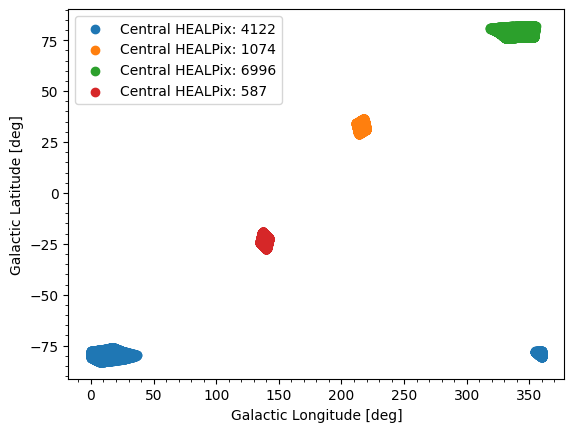

In [13]:
results_dict = points_in_healpix_region(
    central_healpixels=pixels,
    nside=32,
    num_points=100000,
    offset=10
)
c = 0
for i in range(len(results_dict)):
    lon_temp = results_dict['lonc'][i]
    lat_temp = results_dict['latc'][i]
    region_temp = results_dict['region'][i]
    pixel_temp = results_dict['pixels'][i]

    plt.scatter(lon_temp, lat_temp, c = f'C{c}', label = f'Central HEALPix: {region_temp}')
    c = c + 1
plt.gca().minorticks_on()
plt.legend()
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.show()
plt.close()

## Create the mapping of healpix (level 5) id to the region. We use the central pixel's id as the region

In [14]:
flat_hpix = np.concatenate(all_neighs).astype(int)
regions   = np.concatenate([np.full(len(arr), arr[0], dtype=int) for arr in all_neighs])

region_healpix_pdf = pd.DataFrame({
    "healpix_5": flat_hpix,
    "region": regions
})

mapping_df = spark.createDataFrame(region_healpix_pdf)

In [15]:
region_healpix_pdf

healpix_5  region
0        4122    4122
1        4111    4122
2        4133    4122
3        4144    4122
4        4145    4122
5        4123    4122
6        4121    4122
7        4120    4122
8        4109    4122
9        1074    1074
10       1063    1074
11       1069    1074
12       1080    1074
13       1081    1074
14       1075    1074
15       1073    1074
16       1072    1074
17       1061    1074
18       6996    6996
19       6993    6996
20       6995    6996
21       6998    6996
22       6999    6996
23       6997    6996
24       6655    6996
25       6654    6996
26       6651    6996
27        587     587
28        586     587
29        608     587
30        609     587
31        612     587
32        590     587
33        588     587
34        585     587
35        584     587

In [16]:
df = df.join(mapping_df, on="healpix_5", how="left")

## We repartition the dataframe by `region` so that each region is stored in its own partition, enabling efficient parallel processing when applying region-wise clustering.

In [17]:
df = df.repartition("region")

## `applyInPandas` requires us to specify the exact schema of the returned dataframe.
## We copy the original dataframe schema and append a new column, `cluster_label`, that stores the HDBSCAN cluster assignment for each star.

In [18]:
output_schema = StructType(
    [StructField(c.name, c.dataType, c.nullable) for c in df.schema] + 
    [StructField("cluster_label", IntegerType(), True)])

In [19]:
# Features for HDBSCAN
feature_cols = [
    'l',
    'b',
    'pmra',
    'pmdec',
    'parallax'
]

# ----------------------------------------------------------
# Function used with applyInPandas
# ----------------------------------------------------------
def run_hdbscan(pdf: pd.DataFrame) -> pd.DataFrame:

    # Extract features
    X = pdf[feature_cols].to_numpy()

    # Only wrap l when values appear in both the first (0..90) and fourth (270..360) quadrants (i.e. cross the 0/360 boundary).
    if 'l' in feature_cols:
        idx = feature_cols.index('l')
        lvals = X[:, idx].astype(float)
        l360 = np.mod(lvals, 360.0)  # normalize to [0,360)
        if (np.max(l360) - np.min(l360)) > 180:
            # wrap to [-180,180]
            wrapped = ((lvals + 180.0) % 360.0) - 180.0
            X[:, idx] = wrapped
            # update the dataframe column so pdf reflects the wrapped longitudes
            pdf = pdf.copy()
            pdf.loc[:, 'l'] = wrapped

    # Scale features
    scaler = RobustScaler()
    X = scaler.fit_transform(X)

    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=40,
        min_samples=10, cluster_selection_method='leaf'
    )
    clusterer.fit(X)
    labels = clusterer.labels_

    # Add cluster labels to the original dataframe
    pdf["cluster_label"] = labels

    return pdf

## Apply per HEALPix region

### We cache the HDBSCAN results so they can be reused later without repeating the computation.

In [20]:
result = df.groupBy("region").applyInPandas(run_hdbscan, schema=output_schema).cache()
result.count()

473590

# First Look for a particular region

In [21]:
region_id = pixels[0]
region_df_1 = result.filter(result.region == region_id)

## Calling `toPandas()` triggers Spark to execute all pending tasks and collect the full dataset to the driver node. 
## This converts the distributed Spark DataFrame into a local pandas DataFrame stored in the driver’s memory. 

## ⚠️ Avoid using `toPandas()` on large datasets, as it can easily exceed local memory and cause failures.


In [22]:
region_pdf_1 = region_df_1.toPandas()

In [23]:
region_pdf_1

healpix_5            source_id          ra        dec  parallax  \
0           4109  2313288592720110464    1.337350 -33.089380  0.150808   
1           4109  2313352330034975616    2.561523 -32.757110  1.378919   
2           4111  2314718335792588288    0.168280 -31.199100  0.638531   
3           4111  2314737474167851136  359.958546 -30.921001  0.548915   
4           4120  2319389306001294464    3.162105 -32.399879  0.820393   
...          ...                  ...         ...        ...       ...   
64925       4144  2333364030071417856  359.666067 -28.072373  1.010905   
64926       4144  2333425460987427712    0.002553 -27.423470  4.115881   
64927       4145  2333755177037703424    1.223368 -27.290375  1.266635   
64928       4145  2333853896860602496    1.473496 -27.076835  4.406716   
64929       4145  2333864544084531072    1.438449 -26.917959  0.507298   

            pmra      pmdec  phot_g_mean_mag  phot_bp_mean_mag  \
0      11.928889  -1.194541        19.340775         20.022566   
1      -0.736227  -0.252194        20.382496         20.483582   
2       0.727443  -2.474182        20.221231         20.253647   
3       1.534506  -0.190973        17.427620         17.956980   
4       1.464360  -9.607099        14.859123         15.146690   
...          ...        ...              ...               ...   
64925  -2.021918  -2.523519        16.505215         16.978052   
64926 -23.486146  -9.234998        18.820526         20.088936   
64927  -1.039600   3.013560        12.887402         13.268191   
64928   8.565764 -12.440173        20.774105         20.699327   
64929   4.605813  -3.477289        20.508394         20.821495   

       phot_rp_mean_mag          l          b  region  cluster_label  
0             18.657728  -0.754572 -78.397356    4122             -1  
1             19.790674  -1.809865 -79.458160    4122             -1  
2             19.886784   9.738191 -78.202939    4122             -1  
3             16.760809  11.283320 -78.107853    4122             -1  
4             14.386906  -1.467270 -80.074626    4122             -1  
...                 ...        ...        ...     ...            ...  
64925         15.793609  25.268712 -78.275716    4122             -1  
64926         17.610186  28.502445 -78.573892    4122             -1  
64927         12.337362  29.369934 -79.653982    4122             -1  
64928         19.763065  30.621182 -79.867624    4122             -1  
64929         19.720268  31.510677 -79.827203    4122             -1  

[64930 rows x 14 columns]

## Plot the HDBSCAN Output

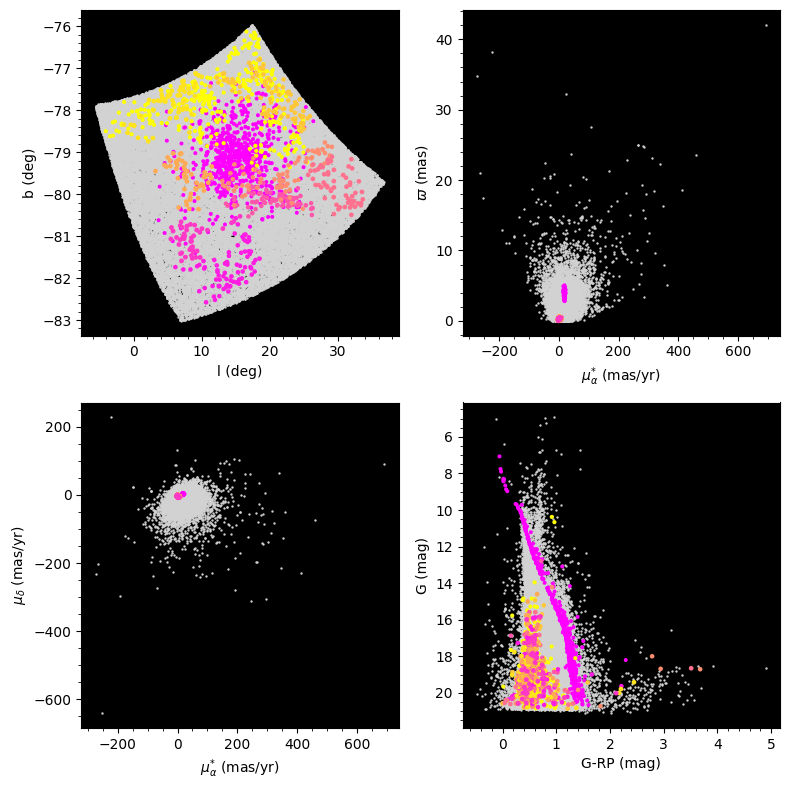

In [24]:
plot_clustering_output(region_pdf_1, plot_noise=True, facecolor='black', cmap = 'spring') # Blanco_1

In [25]:
region_id = pixels[1]
region_df_2 = result.filter(result.region == region_id)
region_pdf_2 = region_df_2.toPandas()

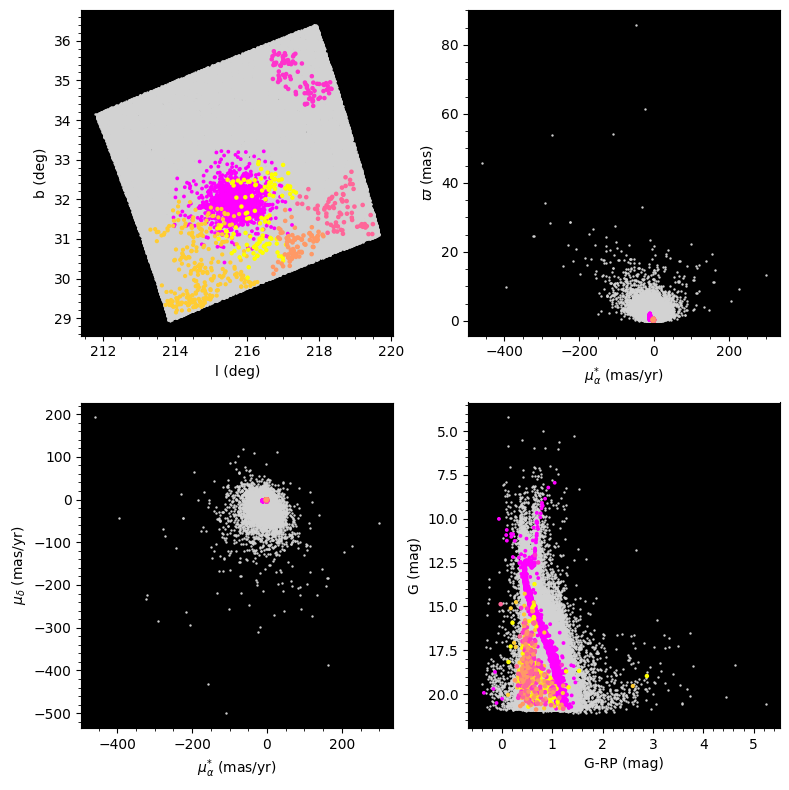

In [26]:
region_pdf_2['g_rp'] = region_pdf_2['phot_g_mean_mag'] - region_pdf_2['phot_rp_mean_mag']
plot_clustering_output(region_pdf_2, plot_noise=True, facecolor='black', cmap = 'spring')   # NGC 2682

In [27]:
region_id = pixels[3]
region_df = result.filter(result.region == region_id)
region_pdf = region_df.toPandas()

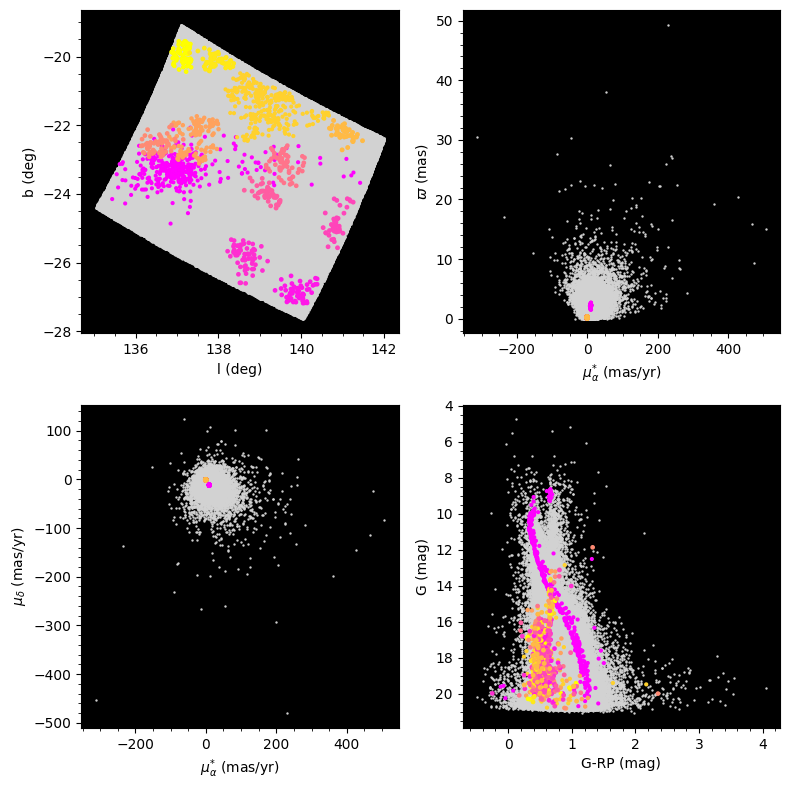

In [28]:
region_pdf['g_rp'] = region_pdf['phot_g_mean_mag'] - region_pdf['phot_rp_mean_mag']
plot_clustering_output(region_pdf, plot_noise=True, facecolor='black', cmap = 'spring')      # NGC 752

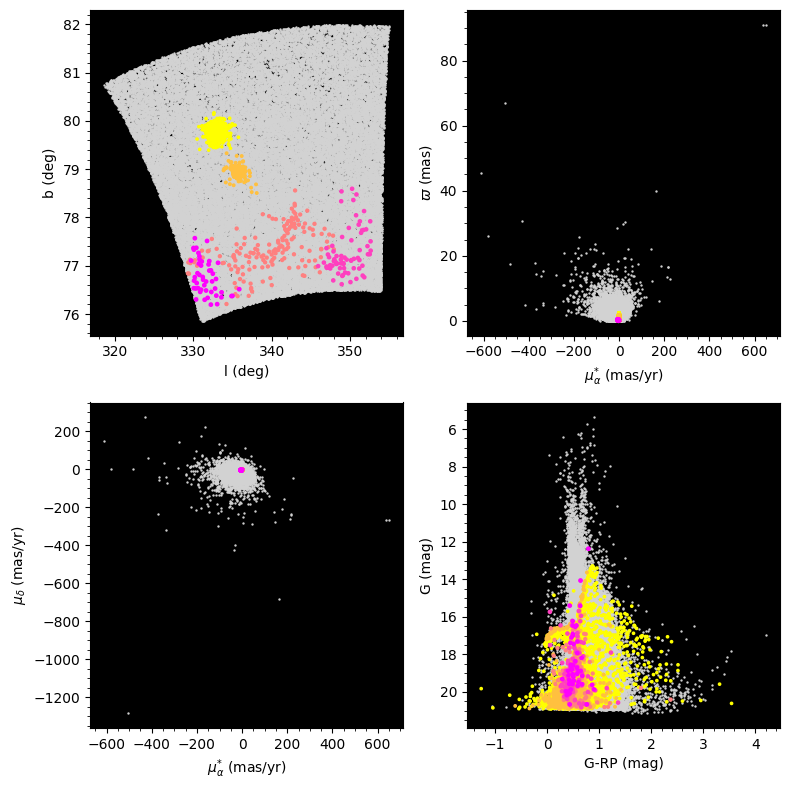

In [29]:
region_id = pixels[2]
region_df = result.filter(result.region == region_id)
region_pdf = region_df.toPandas()
region_pdf['g_rp'] = region_pdf['phot_g_mean_mag'] - region_pdf['phot_rp_mean_mag']
plot_clustering_output(region_pdf, plot_noise=True, facecolor='black', cmap = 'spring')         # NGC 5053 (Globular Cluster)

# Major challenges: False positives (HDBSCAN) and duplicates (data partitioning)

## ⚠️[Hunt & Reffert 2023](https://arxiv.org/abs/2303.13424) ran an all-sky search for OCs in *Gaia* DR3 and detected about **7.1 million** clusters (including duplicates), most of which were false positives. The cleaning and merging process they employed was mostly manual.

# Optional: Using Gaussian Mixture Model

## We only use the central healpix for this case

In [30]:
pix = 1074
neigh = [pix]

sql_query = f"""
SELECT source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, l, b, floor(source_id / {divisor}) as healpix_5
FROM gaiadr3.gaia_source
WHERE floor(source_id / {divisor}) IN ({', '.join(map(str, neigh))})
AND parallax > 0
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND phot_g_mean_mag IS NOT NULL
AND phot_bp_mean_mag IS NOT NULL
AND phot_rp_mean_mag IS NOT NULL
"""

In [31]:
def run_gmm(pdf: pd.DataFrame) -> pd.DataFrame:
    
    X = pdf[feature_cols].to_numpy()

    # === Handle longitude wrap-around ===
    if 'l' in feature_cols:
        idx = feature_cols.index('l')
        lvals = X[:, idx].astype(float)
        l360 = np.mod(lvals, 360.0)
        if (np.max(l360) - np.min(l360)) > 180:
            wrapped = ((lvals + 180.0) % 360.0) - 180.0
            X[:, idx] = wrapped
            pdf.loc[:, 'l'] = wrapped

    # === Scale features ===
    scaler = RobustScaler()
    X = scaler.fit_transform(X)

    n_samples = X.shape[0]
    if n_samples == 0:
        pdf["gmm_label"] = []
        return pdf

    # Max possible clusters cannot exceed #samples
    max_k = min(10, n_samples)

    # === Use BIC to choose best number of components ===
    best_bic = np.inf
    best_gmm = None
    best_k = 1

    for k in range(1, max_k + 1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type='full',
            random_state=42
        )
        gmm.fit(X)
        bic = gmm.bic(X)
        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm
            best_k = k

    # === Predict labels using best GMM ===
    labels = best_gmm.predict(X)

    pdf["gmm_label"] = labels
    pdf["gmm_k"] = best_k     # optional: store chosen k

    return pdf

In [32]:
output_schema_gmm = StructType(
    [StructField(c.name, c.dataType, c.nullable) for c in df.schema] +
    [
        StructField("gmm_label", IntegerType(), True),
        StructField("gmm_k", IntegerType(), True)
    ]
)

In [33]:
df_gmm = spark.sql(sql_query)

rows = [(int(p), int(pix)) for p in neigh]

schema = StructType([
    StructField("healpix_5", LongType(), False),
    StructField("region",    LongType(), False),
])

mapping_df = spark.createDataFrame(rows, schema=schema)

# join on healpix_5...same as earlier
df_gmm = df_gmm.join(mapping_df, on="healpix_5", how="left")

In [34]:
result = df_gmm.groupBy("region").applyInPandas(run_gmm, schema=output_schema_gmm).cache()
result.count()

14757

In [35]:
region_pdf_1 = result.toPandas()

### Only plotting a particular gmm label

/tmp/ipykernel_8348/3063285289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_field_df['g_rp'] = cluster_field_df['phot_g_mean_mag'] - cluster_field_df['phot_rp_mean_mag']


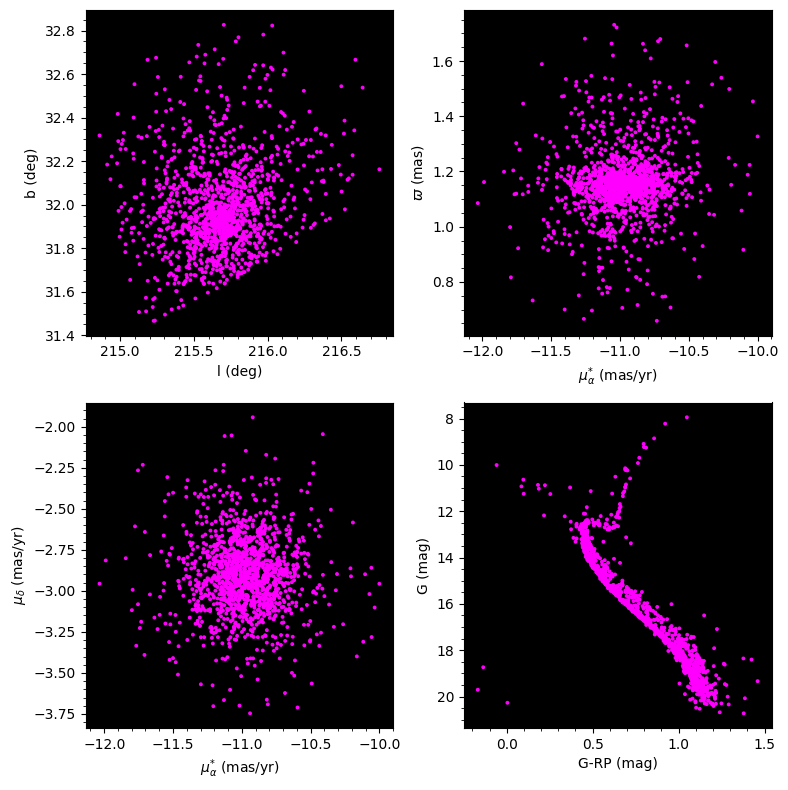

In [39]:
plot_clustering_output(region_pdf_1[region_pdf_1['gmm_label'] == 0], plot_noise=True, facecolor='black', cmap = 'spring', cluster_label_col='gmm_label')